In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
df = pd.read_csv("data/mexico-city-real-estate.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11799 entries, 0 to 11798
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        11799 non-null  float64
 1   surface_covered_in_m2  11275 non-null  float64
 2   lat                    10875 non-null  float64
 3   lon                    10875 non-null  float64
 4   neighborhood           11799 non-null  object 
dtypes: float64(4), object(1)
memory usage: 461.0+ KB


In [5]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    width=1000,
    height=800,
    center={"lat": 19.43,"lon": -99.13},
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)
fig.update_layout(mapbox_style="open-street-map")

fig.show()

### Split

In [6]:
# Split data into feature matrix "X_train" and target vector "y_train"
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]
X = df[features]
y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Build Model
#### Baseline

In [7]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean price:", round(y_mean, 2))
print("Baseline MAE:", round(baseline_mae, 2))

Mean price: 110857.11
Baseline MAE: 67195.33


In [8]:
# Build Model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

### Evaluate

In [9]:
# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate the MAE of the test data
mae_test = mean_absolute_error(y_test, y_test_pred)

print("Mean Absolute Error (Test Data):", round(mae_test, 2))

Mean Absolute Error (Test Data): 56527.02


### Communicate Results

In [10]:
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index=features)
feat_imp.abs().sort_values()

surface_covered_in_m2                       0.000074
lat                                      3035.950470
neighborhood_Coyoacán                    3738.439541
neighborhood_Cuauhtémoc                 13580.780240
lon                                     14510.576641
neighborhood_Tlalpan                    21248.105254
neighborhood_Miguel Hidalgo             31067.977744
neighborhood_Álvaro Obregón             32596.372186
neighborhood_Azcapotzalco               33304.522185
neighborhood_Xochimilco                 33798.315046
neighborhood_Gustavo A. Madero          35276.762426
neighborhood_Venustiano Carranza        42305.599477
neighborhood_Benito Juárez              44283.336521
neighborhood_Iztacalco                  44723.591054
neighborhood_Iztapalapa                 54174.063682
neighborhood_Tláhuac                    55189.641333
neighborhood_La Magdalena Contreras     58219.351694
neighborhood_Cuajimalpa de Morelos     101515.011105
dtype: float64

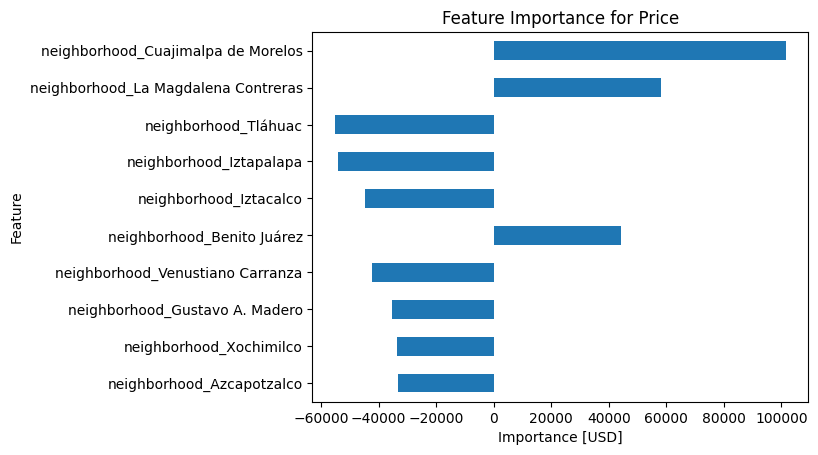

In [11]:
# Build bar chart
feat_imp.sort_values(key=abs).tail(10).plot(kind="barh")
# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")

# Add title
plt.title("Feature Importance for Price");

In [12]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [13]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=7849, description='area', max=65748000), FloatSlider(value=19.4832274885…